<a href="https://colab.research.google.com/github/RazvanRotaru/StyleTransferRevolution/blob/main/Style_Transfer_Revolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##YOLO v5

In [2]:
!git clone https://github.com/RazvanRotaru/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-113-g5fb15f0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅


### Upload Images

In [3]:
from google.colab import files
import os

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

#### Content Image

In [5]:
content_im = files.upload()
os.environ['content_img'] = list(content_im)[0]

Saving squirel_apple.png to squirel_apple.png


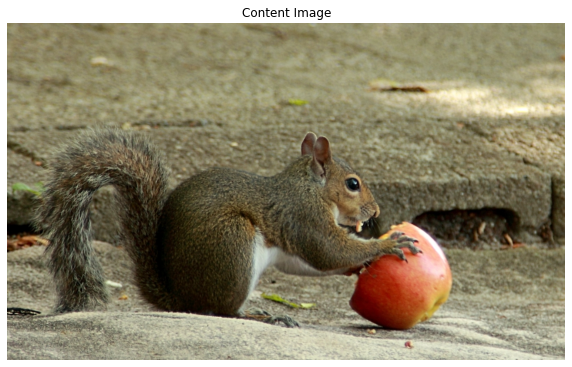

In [6]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(os.environ['content_img'])
plt.axis('off')
plt.title('Content Image')
plt.imshow(img)

#### Style Image

In [50]:
%cd /content/yolov5
style_im = files.upload()
os.environ['global_style_img'] = list(style_im)[0]
os.environ['global_style_img'] = f"/content/yolov5/{os.environ['global_style_img']}"

/content/yolov5


Saving s-l400.jpg to s-l400.jpg


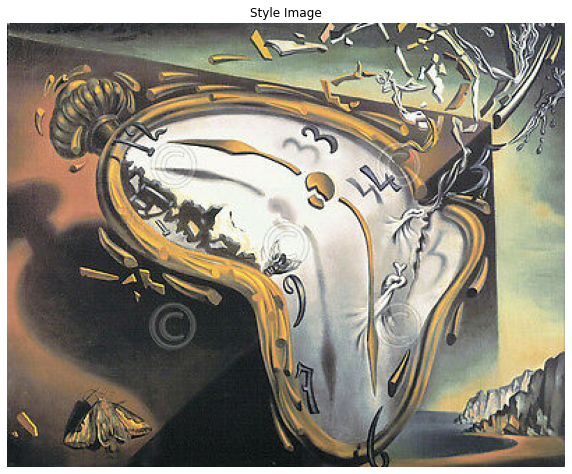

In [51]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(os.environ['global_style_img'])
plt.axis('off')
plt.title('Style Image')
plt.imshow(img)

### Detect objects in content image

In [9]:
%cd /content/yolov5/
%rm /content/yolov5/runs/detect/crops/*
!python detect.py --weights yolov5s.pt --save-crop --img 640 --conf 0.25 --source ${content_img}

/content/yolov5
rm: cannot remove '/content/yolov5/runs/detect/crops/*': No such file or directory
detect: weights=['yolov5s.pt'], source=squirel_apple.png, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-113-g5fb15f0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

100% 14.0M/14.0M [00:00<00:00, 89.7MB/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/yolov5/squirel_apple.png: 416x640 1 bear, 1 apple, Done. (0.031s)
Speed: 1.1ms pre-process, 31.3ms inference, 45.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect


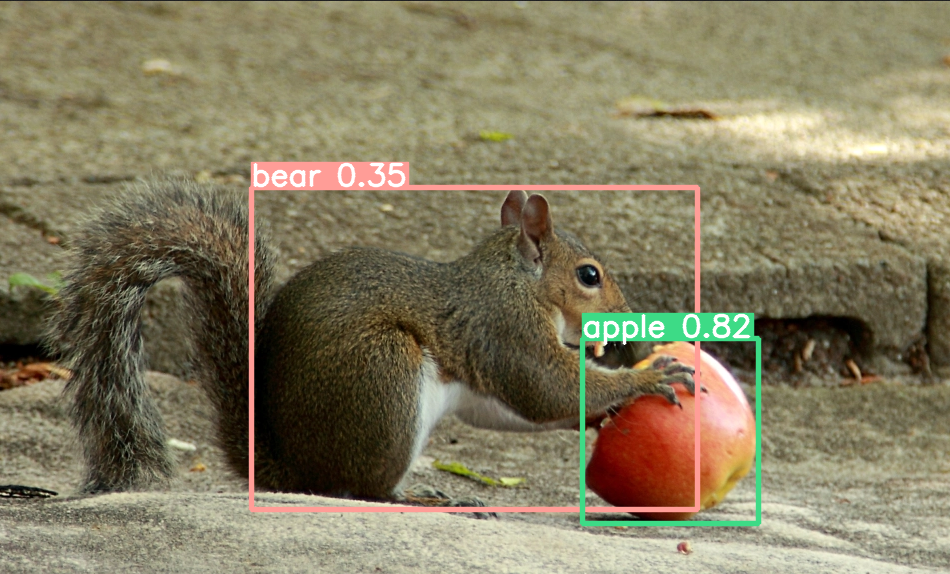

In [10]:
display.Image(filename=f"runs/detect/{os.environ['content_img']}", width=600)

In [11]:
%cd /content

/content


## Warping

In [12]:
!git clone https://github.com/RazvanRotaru/DST
%cd DST

Cloning into 'DST'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 63 (delta 18), reused 37 (delta 2), pack-reused 0
Unpacking objects: 100% (63/63), done.
/content/DST


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils_misc import pil_loader, pil_resize_long_edge_to, pil_to_tensor

#### Variables

In [14]:
%env nbb_base = example/NBBresults
%env clean_base = example/CleanedPts
%env dst_base = example/DSTresults
%env output_prefix = example

env: nbb_base=example/NBBresults
env: clean_base=example/CleanedPts
env: dst_base=example/DSTresults
env: output_prefix=example


In [15]:
# Image will be resized to have a long side of im_side
%env im_size = 256

# If you choose cuda, make sure you select GPU under [Runtime]-[Change runtime type]
%env device = cuda

# Set paths and other parameters for cleaning points
%env NBB = 1
%env max_num_points = 80
%env b = 5

env: im_size=256
env: device=cuda
env: NBB=1
env: max_num_points=80
env: b=5


In [16]:
%env max_iter = 250
%env checkpoint_iter = 50
%env content_weight = 8
%env warp_weight = 1
%env reg_weight = 5
%env optim = sgd
%env lr = 0.1
%env verbose = 0
%env save_intermediate = 1
%env save_extra = 0

env: max_iter=250
env: checkpoint_iter=50
env: content_weight=8
env: warp_weight=1
env: reg_weight=5
env: optim=sgd
env: lr=0.1
env: verbose=0
env: save_intermediate=1
env: save_extra=0


#### Run NBB and DST for every detected object

Get All Detected Objects

In [17]:
relevant_path = "/content/yolov5/runs/detect/crops"
included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
crops = [f"{relevant_path}/{fn}" for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

In [18]:
print(crops)

['/content/yolov5/runs/detect/crops/squirel_apple2.jpg', '/content/yolov5/runs/detect/crops/squirel_apple.jpg']


Upload Style Images 

In [19]:
styles = []
curr_dir = !pwd

**Re-run this cell to upload multiple style**

In [20]:
#--NotebookApp.iopub_data_rate_limit=1.0e10

In [21]:
content_im = list(files.upload())

styles += [f"{curr_dir[0]}/{fn}" for fn in content_im]

print(styles)

Saving ghibli.jpg to ghibli.jpg
Saving style.png to style.png
['/content/DST/ghibli.jpg', '/content/DST/style.png']


In [22]:
from cleanpoints import clean_points
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils_misc import pil_loader, pil_resize_long_edge_to, pil_to_tensor

In [23]:
def file_name(path): 
  _, filename = os.path.split(path)
  return os.path.splitext(filename)[0]

def specific_path(path, content, style):
  return f"{path}/{file_name(content)}/{file_name(style)}"

/content/yolov5/runs/detect/crops/squirel_apple2.jpg
env: content_path=/content/yolov5/runs/detect/crops/squirel_apple2.jpg
env: style_path=/content/DST/ghibli.jpg
env: pts_path=example/NBBresults/squirel_apple2/ghibli
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:05<00:00, 110MB/s]


---------------------------
Started Neural Best-Buddies
---------------------------
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "

Finding best-buddies for the 5-th level
Scaling and drawing correspondence...

Finding best-buddies for the 4-th level
Scaling and drawing correspondence...

Finding best-buddies for the 3-th level
Scaling and drawing correspondence...

Finding

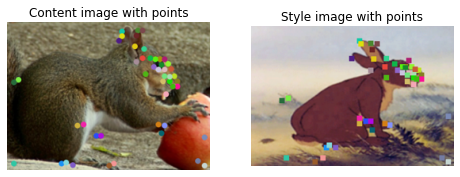

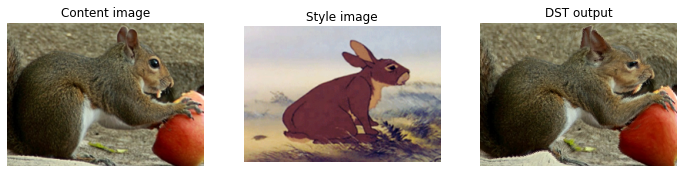

In [24]:
root_pts_path = os.environ['nbb_base']
warped_result_paths = []
for crop in crops:
  print(crop)
  max_points = 0
  crop_activation_path = ''
  crop_output_path = ''
  crop_content_pts_path = ''
  crop_style_pts_path = ''
  crop_pts_path = ''

  for style in styles:
    # os.environ['content_path'] = list(crop)[0]
    # os.environ['style_path'] = list(style)[0]
    %env content_path = $crop
    %env style_path = $style

    crop_pts_path = specific_path(root_pts_path, crop, style)
    %env pts_path = $crop_pts_path
    
    activation_path = crop_pts_path + '/correspondence_activation.txt'
    curr_content_pts_path = crop_pts_path + '/correspondence_A.txt'
    curr_style_pts_path = crop_pts_path + '/correspondence_B.txt'
    output_path = specific_path(os.environ['clean_base'], crop, style)

    # Load and resize input images
    content_pil = pil_resize_long_edge_to(pil_loader(os.environ['content_path']), int(os.environ['im_size']))
    width, height = content_pil.size
    style_pil = pil_resize_long_edge_to(pil_loader(os.environ['style_path']), int(os.environ['im_size']))
    content_im_orig = pil_to_tensor(content_pil).to(os.environ['device'])
    style_im_orig = pil_to_tensor(style_pil).to(os.environ['device'])

    # Plot images
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
    plt.subplot(1, 2, 2)
    plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');

    # Run NBB
    !python NBB/main.py --results_dir ${pts_path} --imageSize ${im_size} --fast \
        --datarootA ${content_path} --datarootB ${style_path}
  
    # Clean NBB points
    points = clean_points(crop, style, curr_content_pts_path, curr_style_pts_path,
      activation_path, output_path, int(os.environ['im_size']), os.environ['NBB'] ,int(os.environ['max_num_points']), int(os.environ['b']))

    # Load and plot images with points marked
    content_marked = output_path + '/A_selected_final.png'
    style_marked = output_path + '/B_selected_final.png'
    content_marked_pil = pil_resize_long_edge_to(pil_loader(content_marked), int(os.environ['im_size']))
    style_marked_pil = pil_resize_long_edge_to(pil_loader(style_marked), int(os.environ['im_size']))

    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(content_marked_pil); plt.axis('off'); plt.title('Content image with points');
    plt.subplot(1, 2, 2)
    plt.imshow(style_marked_pil); plt.axis('off'); plt.title('Style image with points');

    if points > max_points:
      max_points = points
      crop_content_pts_path = curr_content_pts_path.replace('NBBresults', 'CleanedPts')
      crop_style_pts_path = curr_style_pts_path.replace('NBBresults', 'CleanedPts')

  %env content_pts_path = $crop_content_pts_path
  %env style_pts_path = $crop_style_pts_path
  crop_output_dir = specific_path(os.environ['dst_base'], crop, 'warped')
  %env output_dir = $crop_output_dir

  # Run DST
  !python -W ignore main.py ${content_path} ${style_path} ${content_pts_path} ${style_pts_path} \
        ${output_dir} ${output_prefix} ${im_size} ${max_iter} \
          ${checkpoint_iter} ${content_weight} ${warp_weight} ${reg_weight} ${optim} \
            ${lr} ${verbose} ${save_intermediate} ${save_extra} ${device}

  result_path = f"{specific_path(os.environ['dst_base'], crop, 'warped')}/{os.environ['output_prefix']}.png"
  warped_result_paths.append( f"/content/DST/{result_path}");
  # %env result_path = result_path

  # Load the output image
  result_pil = pil_resize_long_edge_to(pil_loader(result_path), int(os.environ['im_size']))

  # Plot input and output images
  fig = plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
  plt.subplot(1, 3, 2)
  plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');
  plt.subplot(1, 3, 3)
  plt.imshow(result_pil); plt.axis('off'); plt.title('DST output');

In [39]:
%cd /content

/content


## Blend warped objects back in the content image

In [26]:
def warped_path(img_name):
  return f"/content/DST/{os.environ['dst_base']}/{img_name}/warped/{os.environ['output_prefix']}.png"

env: warped_img_path=/content/warped_result/final_warp.png


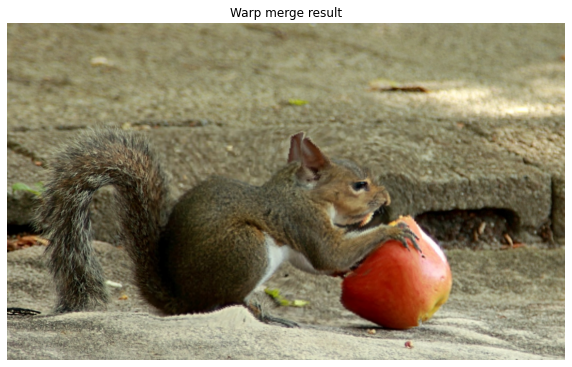

In [27]:
import torch
import numpy as np
import cv2 

orig_img = cv2.imread('/content/yolov5/' + os.environ['content_img'])

relevant_path = "/content/yolov5/runs/detect/crops"
included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']
cropped_imgs = [fn for fn in os.listdir(relevant_path) if any(fn.endswith(ext) for ext in included_extensions)]

for img in cropped_imgs:
    cropped_img_path = f"{relevant_path}/{img}"
    bbox_path =  f"{relevant_path}/{file_name(img)}.bbox"
    warped_img_path = warped_path(file_name(img))


    region = cv2.imread(cropped_img_path)
    warped_img = cv2.imread(warped_img_path)
    bbox = torch.load(bbox_path)

    # extract region 
    top = int(bbox[0, 1])
    bottom = int(bbox[0, 3])

    left = int(bbox[0, 0])
    right = int(bbox[0, 2])

    # rescale warped image 
    width, height = region.shape[0:2]
    warp_img_resized = cv2.resize(warped_img, (height, width) )
    orig_img[top:bottom, left:right, :3] = warp_img_resized

%mkdir -p /content/warped_result
%env warped_img_path = /content/warped_result/final_warp.png
cv2.imwrite(os.environ['warped_img_path'], orig_img)

orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Warp merge result')
plt.imshow(orig_img)
plt.show()



In [28]:
%cd /content

/content


## Neural Style Transfer - STROTSS




In [52]:
!git clone https://github.com/futscdav/strotss
%cd /content/strotss

/content/strotss


In [53]:
%env final_output = /content/final.png
%env content_loss_weight = 0.8

env: final_output=/content/final.png
env: content_loss_weight=0.8


In [ ]:
!python strotss.py ${warped_img_path} ${global_style_img} --weight ${content_loss_weight} --output ${final_output} --device ${device} --resize_to 1024

Optimizing at resoluton [38, 64]
Optimizing at resoluton [77, 128]
Optimizing at resoluton [154, 256]
Optimizing at resoluton [309, 512]


In [ ]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(os.environ['final_output'])
plt.axis('off')
plt.title('Result')
plt.imshow(img)